# Topic: What kinds of books are highly rated?

**Name:** Zhiying Li <br>

**Introduction:**

This report is to find out the characteristics of highly rated books. Compared to the review numbers and prices, the ratings are more likely to represent the feedback from readers, which probably indicates that books with higher rates are of good quality. There are several premises to this analysis. Firstly, I assume that the ratings for the website are reasonable. Secondly, since the average rating is 2.5, therefore the high rating books are more than 2.5 stars.


# Step 1: Data scraping

Scrape 1000 books (all books) from the website and save result 

In [18]:
# All the code for Task 1 in one cell.
# Explain your code with comments.
from IPython.display import HTML
import numpy as np
import urllib.request  # not that necessary
import bs4  # this is beautiful soup
import time
import re  # regular expressions IMP
from bs4 import BeautifulSoup
import requests  # IMP
from pandas import Series
import pandas as pd
from pandas import DataFrame
import json
import matplotlib
import matplotlib.pyplot as plt
# matplotlib inline

import seaborn as sns

sns.set_context("talk")
sns.set_style("white")

baseURL = "http://books.toscrape.com/"


import json
import csv
# get html
def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return (soup)


def getBooksURLs(url):
    soup = getAndParseURL(url)
    nextElement = soup.select('li.next>a')
    prevElement = soup.select('li.previous>a')
    typeList = [baseURL + x.a.get('href') for x in soup.findAll("div", class_="image_container")]
    for index in range(len(typeList)):
        #  test whether there is 'catelogue' in the path
        if typeList[index].find('catalogue') == -1:
            # replace the string
            typeList[index] = typeList[index].replace("http://books.toscrape.com/", "http://books.toscrape.com/catalogue/")

    # check whether there is a  next page 
    if (len(nextElement)) > 0:
        typeHref = soup.select('li.next>a')[0].get('href')
        # if there is no 'catalogue', then combine it with the path
        if typeHref.find('catalogue') == -1:
            typeHref = "%s/%s" % ("catalogue", typeHref)
        # format the data and returen
        return {
            # nextpage button
            'nextUrl': "%s%s" % (baseURL, typeHref),
            'nextBtn': True,
            # get list of book
            'bookList': typeList
        }
    else:
        if len(prevElement) > 0 or prevElement[0].get('href').find('49') != -1:
            return {
                # nextpage button
                'nextBtn': False,
                'nextUrl': '',
                'bookList': typeList
            }


# write into json
def writeJSON(data):
    with open('typeUrlList.json', 'w', encoding='utf8') as file:
        file.write(json.dumps(data))


bookList = []
url = "http://books.toscrape.com/index.html"

# use loop to get links
while True:
    booksURLs = getBooksURLs(url)
    bookList.extend(booksURLs['bookList'])
    # test if there is a next page
    if booksURLs['nextUrl'] != '':
        url = booksURLs['nextUrl']
    if len(bookList) == 1000:
        writeJSON(bookList)
        break
    #print(booksURLs['bookList'])


def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return (soup)


# get details of each book item
def getBookDetails(url):
    # get url
    soup = getAndParseURL(url)
    time.sleep(1)
    # title
    title = soup.select('h1')[0].get_text()
    # number of reviews
    review = soup.select('tr')[6].select('td')[0].get_text()
    # set initial rating
    rating = 0
    # get ratings
    if len(soup.select('.product_main>.One')) > 0:
        rating = 1
    elif len(soup.select('.product_main>.Two')) > 0:
        rating = 2
    elif len(soup.select('.product_main>.Three')) > 0:
        rating = 3
    elif len(soup.select('.product_main>.Four')) > 0:
        rating = 4
    elif len(soup.select('.product_main>.Five')) > 0:
        rating = 5
    # product description
    description = ""
    if len(soup.select('#product_description~p')):
        description = soup.select('#product_description~p')[0].get_text()
    # product price
    price=soup.find("p", class_ = "price_color").text[2:]
    # product type
    productType = soup.select('.breadcrumb li')[2].select('a')[0].get_text()
    # book category
    bookCategory = soup.select('.breadcrumb li')[1].select('a')[0].get_text()
    # availability(in stock)    0-9
    availability = ''.join([x for x in soup.select('tr')[5].select('td')[0].get_text() if x.isdigit()])
    #availability = list(map(int, availability))
    availability = int(availability)
    #print(type(availability))
    return title, review, rating, description, price, productType, bookCategory, availability


# write it into csv
def writeCSV():
    with open('bookDetailsList.csv', 'w', encoding='utf8') as file:
        writer = csv.writer(file)
        writer.writerows(detailsList)


detailsList = []

headerRow = [('title', 'review', 'rating', 'description', 'price', 'productType','BookCategory' 'Availability')]
#  use loop to get data in detailed pages
with open('typeUrlList.json', 'r', encoding='utf8') as file:
    # transform the json to list
    urlList = json.loads(file.read())
    for index in range(len(urlList)):
        detailsList.append(getBookDetails(urlList[index]))
        #print(len(detailsList))
    writeCSV()



# Step 2

### Visualize data with 5 kinds of graphs to generate insights
Multiple graphs are used to analyze the review, price, title, category, and description of highly rated books.
Firstly, the bar chart is used to show the average rating scores for each type of book. This provides us with a general view of all ranges of books. After that, the so-called good books are sorted with the condition that the rating is greater than 2. 
Secondly, the PairGrid, colorable by transmission type, allows me to do this comparison for 3 continuous features here, with the diagonal being a kernel density estimate. In this way, we can find out the relationships between prices, reviews, and ratings.
Thirdly, a word cloud is adopted to illustrate the most frequent words included in the sorted high-rating books.
Then, another word cloud for description is shown.
Next, with the distribution of prices among the sorted books, we can infer some suggestions for readers to find high-rated books.
Finally,we can find out the stock for good books in a line graph.
The analysis of results in each step as well as the final suggestions will be discussed at the end of the report.

In [6]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(
        'bookDetailsList.csv', 
        names=['title', 'review', 'rating', 'description', 'price', 'productType', 'bookCategory','availability'],
        skip_blank_lines=True
    )
val = DataFrame(df)

# 1. Pie chart for 5 different ratings

No handles with labels found to put in legend.


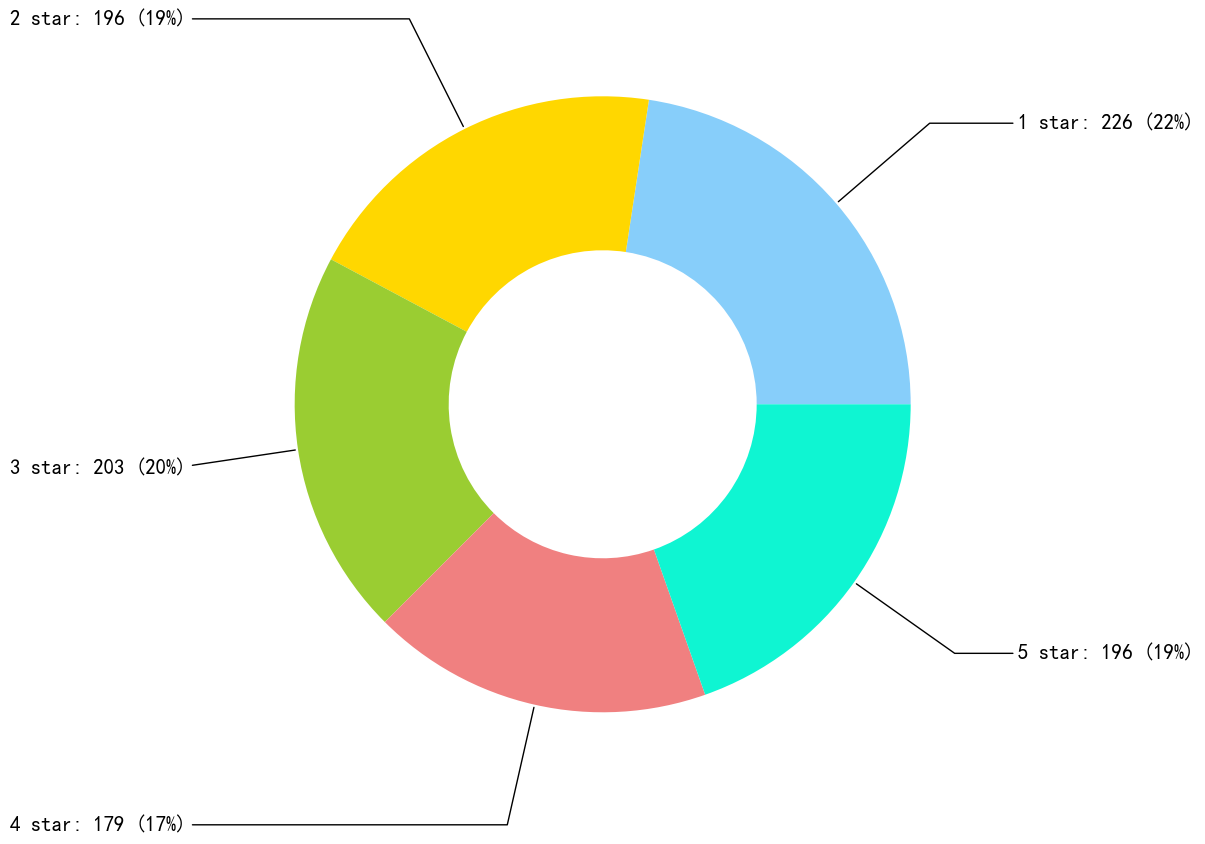

In [25]:

# pie chart for rating 
def plot_pie_failitem(image_path, labellist, numlist):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(15, 10))
    data = {}
    total = sum(numlist)
    i = 0
    while (i < len(labellist)):
        if numlist[i] == 0:
            del labellist[i]
            del numlist[i]
        else:
            data[labellist[i]] = numlist[i]
            i += 1

    plt.rcParams["font.family"] = ["simhei"]

    
    data = pd.DataFrame([data])
    # Draw the circle and define the colors
    colors = ['lightskyblue', 'gold', 'yellowgreen', 'lightcoral', '#0FF5d2', '#A6C7E1', '#1b55e1', '#1FAB8F',
              '#6543FF', '#00FFAA', '#456789', '#CCCC21', '#E6E6FA', '#FFEFD5', '#F0E68C', '#98FB98', '#40E0D0']
    wedges, texts = plt.pie(data.iloc[0], colors=colors, wedgeprops={"width": 0.5})
    # Construct annotate and **kwargsset to set the line type for guide line
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    # Go through each proportion to draw tags and lines遍历饼块绘制注释标签和引导线
    for i, p in enumerate(wedges):
        # According to theta1 and theta2 parameters to calculate angle
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        # Calculation of the coordinates of the pie parity point (starting point of the guide line) based on the radian of the angle
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        # print(p.theta1, p.theta2, ang, np.deg2rad(ang), x, y)
        
        # Determine the alignment of the guide lines based on the value of x
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        # Set the connection of guide line
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        # draw illustration sand tags
        p = int(numlist[i] / total * 100.0)
        plt.annotate(
            data.columns[i] + ': {v:d} ({p:d}%)'.format(p=p, v=numlist[i]),
            xy=(x, y),
            fontsize=15,
            xytext=(1.35 * np.sign(x), 1.4 * y),
            horizontalalignment=horizontalalignment,
            **kw
        )

     
    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.0), borderaxespad=0,  # Format output percentages
               frameon=False)  # set illustrations，use bbox_to_anchor to adjust the position
    # save the picture
    plt.savefig(image_path)  
    plt.show()

#plot_pie_failitem('./', ['1 star', '2 star', '3 star', '4 star', '5 star'], val.loc[:, 'rating'])

def createBarOfRating():
    data = [0, 0, 0, 0, 0]
    for i in val.loc[:, 'rating']:
        data[i - 1] += 1
    plot_pie_failitem('./', ['1 star', '2 star', '3 star', '4 star', '5 star'], data)

createBarOfRating()

# 2. Pairs of graphs to find relationships among ratings, price and reviews

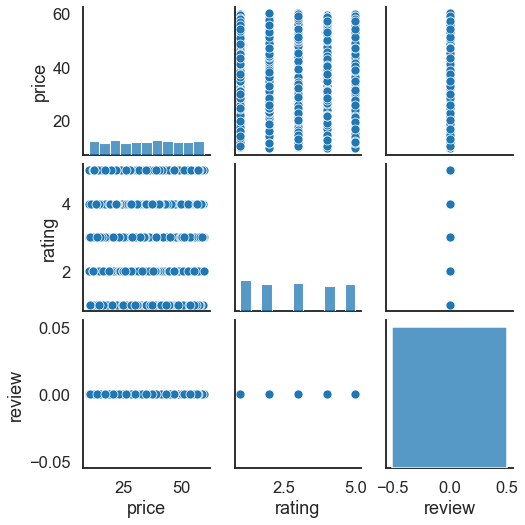

In [8]:
val_short=val[["price", "rating","review"]]
sns.pairplot(val_short, height=2.5)

In [15]:
# we assume that the rating larger than 2 are good books sort out the high rating books to figure out the features
valGood = val.loc[val['rating']>2]
valRT = valGood.loc[:,['rating','productType']].groupby('productType').mean()

# 3. find out what kind of books have higher rating

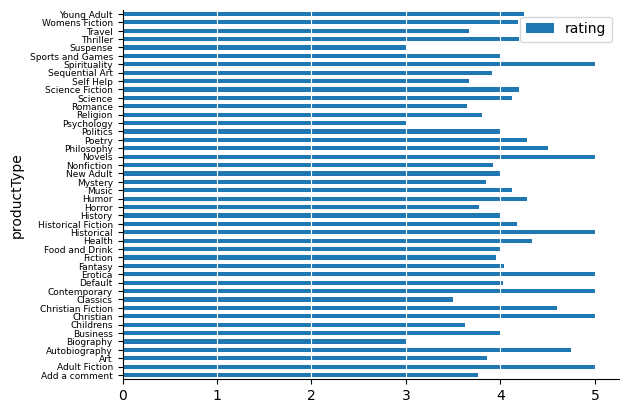

In [16]:
sns.reset_defaults()
valRT.plot(kind="barh")
plt.grid(axis = 'x', color ='white', linestyle='-')
#ax.tick_params(axis='both', which='both',length=20)
plt.yticks(size=6.5)
sns.despine()

# 4.wordcloud for analyzing the description of good books

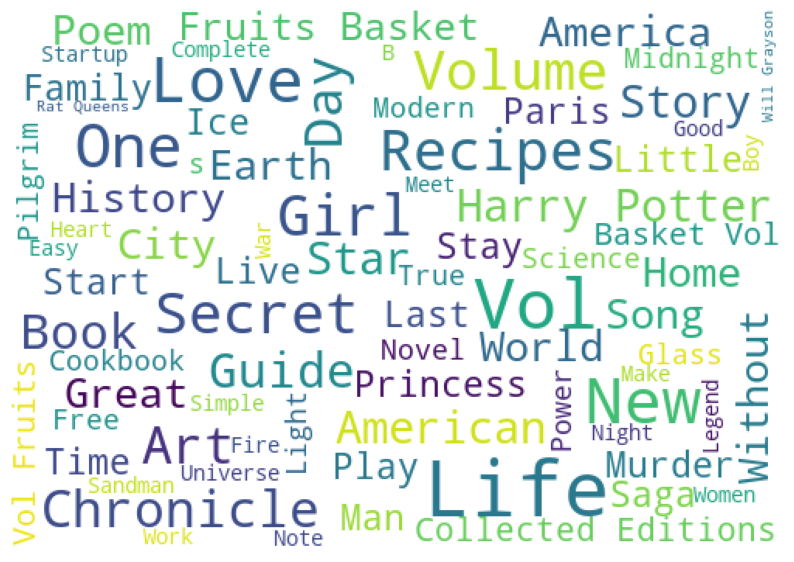

In [29]:
# wordcloud for analyzing the description 
def createWord():
    text = ''
    for item in valGood.loc[:, 'title']:
        if (isinstance(item, str) and item != ''):
            title = item.replace('...more', '')
            text += title
    wc = WordCloud(
        background_color='white',
        #set backgroud width
        width=500,
        # set backgroud height
        height=350,
    
        max_font_size=50,
     
        min_font_size=10,
        mode='RGBA'
        # colormap='pink'
    )
    # generate the wordcloud
    wc.generate(text)
    # save the output
    wc.to_file(r"wordcloud.png") 
    # show the output
    plt.figure(figsize=(10, 10))
    # show the output as wordcloud
    plt.imshow(wc)
    # close axises
    plt.axis("off")
    plt.show()

createWord()


# 6. Price distribution for good books

In [31]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


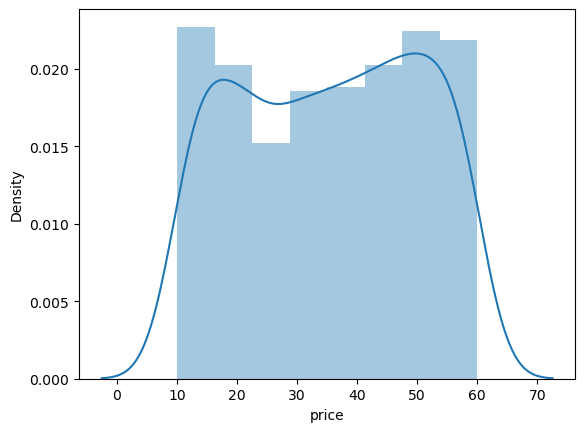

In [20]:
sns.distplot(valGood.price); 

# 7. Inventory for good books

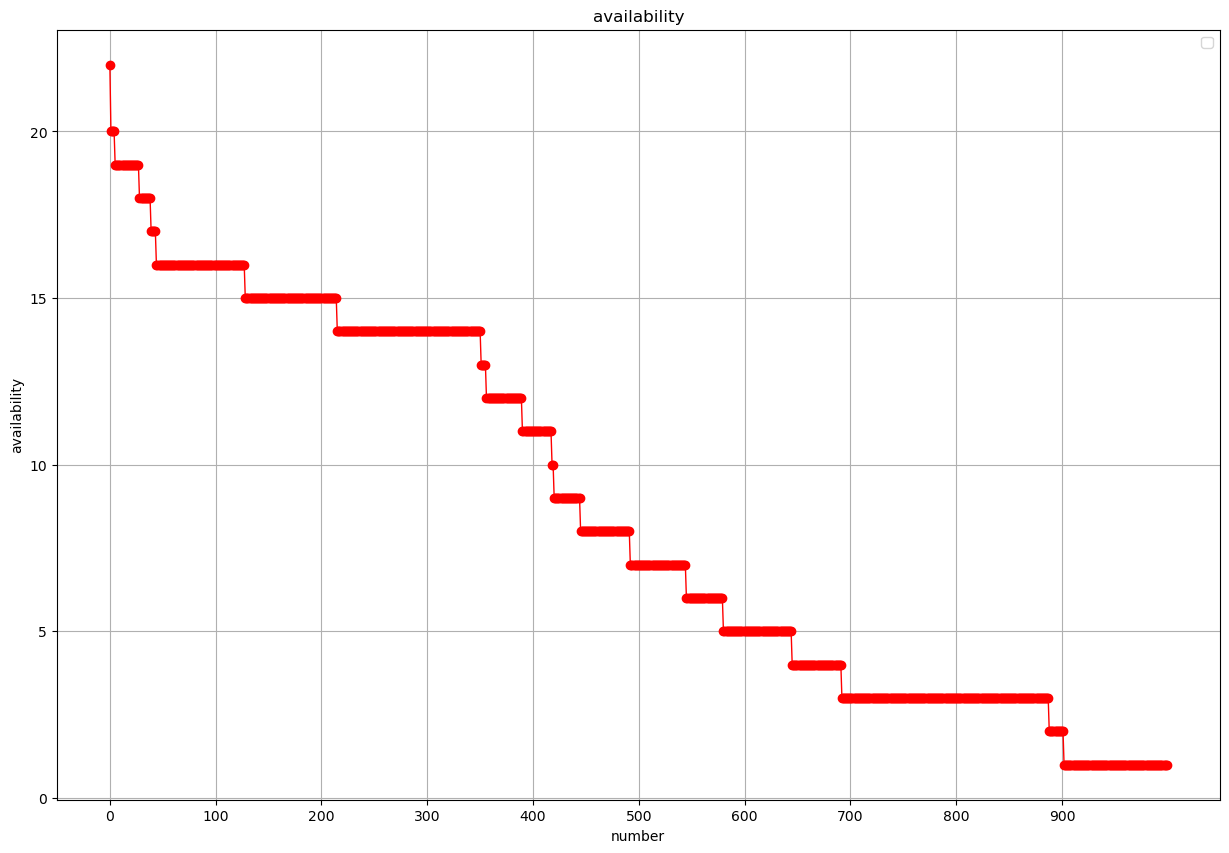

In [17]:
def createLine():
    plt.figure(figsize=(15, 10))
    line_rating = np.asarray(val.loc[:, 'availability'])
    arg_x = range(len(line_rating))
    plt.xlabel('number')
    plt.ylabel('availability')
    plt.title('availability')
    plt.plot(arg_x, line_rating, color='red', marker='o', linewidth='1', label='')
    plt.xticks(range(0, len(line_rating), 100))

    plt.legend()
    plt.grid()
    plt.show()
    
createLine()

# 8. Discussions


**Conclusion:**

To find highly rated books, readers should prioritize books with strong storytelling elements, as indicated by the genre analysis. Titles and descriptions containing themes like "love" and "life" are also indicative of highly rated books. While there is no clear price preference, budget-conscious readers can consider books priced at $10 or below. Additionally, monitoring stock levels can ensure availability of desired titles.

**Insights into Methodology:**

The methodology employed, including the use of bar charts, PairGrids, word clouds, and price distribution analysis, provided a comprehensive understanding of the characteristics of highly rated books. Each method contributed to uncovering different aspects of the data, leading to meaningful insights and actionable recommendations for readers.
